In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from sklearn import datasets
from numpy import linalg as LA
from sklearn.metrics.pairwise import pairwise_distances
import sys
from scipy.stats import entropy
from sklearn.datasets import load_digits
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from scipy.cluster.hierarchy import dendrogram, linkage
from multiprocessing import Pool
import itertools
from scipy.cluster.hierarchy import fcluster
from collections import Counter

In [26]:
#Our Dataset
data = np.array([0.40,0.53,0.22,0.38,0.35,0.32,0.26,0.19,0.08,0.41,0.45,0.30]).reshape(6,2)
print(data)

[[0.4  0.53]
 [0.22 0.38]
 [0.35 0.32]
 [0.26 0.19]
 [0.08 0.41]
 [0.45 0.3 ]]


In [3]:
digits = load_digits()
targets = digits.target
digits.data.shape

(1797, 64)

Visualising Data

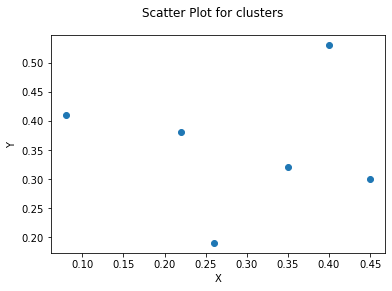

In [4]:
fig = plt.figure()
fig.suptitle('Scatter Plot for clusters')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(data[:,0],data[:,1])

  Distance Matrix: It is the matrix which contains distances between all the datapoints. If you have n datapoints, the distance matrix will be of order nXn.
  To calculate distance matrix, we use pairwise distance function of sklearn which returns distance matrix. For hierarchical clustering we use euclidean distance to calculate distance between two datapoints.

In [5]:
def hierarchical_clustering(data,linkage,no_of_clusters, targets, alpha = 0, verbose = False):  
    #first step is to calculate the initial distance matrix
    #it consists distances from all the point to all the point
    color = ['r','g','b','y','c','m','k','w']
    initial_distances = pairwise_distances(data,metric='euclidean')
    #making all the diagonal elements infinity 
    np.fill_diagonal(initial_distances,sys.maxsize)
    clusters = find_clusters(initial_distances,linkage, targets, alpha, verbose) 
    
    #plotting the clusters
    iteration_number = initial_distances.shape[0] - no_of_clusters
    clusters_to_plot = clusters[iteration_number]
    arr = np.unique(clusters_to_plot)
    
    indices_to_plot = []
    fig = plt.figure()
    fig.suptitle('Scatter Plot for clusters')
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for x in np.nditer(arr):
        indices_to_plot.append(np.where(clusters_to_plot==x))
    p=0
    
    print(clusters_to_plot)
    for i in range(0,len(indices_to_plot)):
        for j in np.nditer(indices_to_plot[i]):
               ax.scatter(data[j,0],data[j,1], c= color[p])
        p = p + 1
        
    plt.show()
    

In [6]:
2*sys.maxsize

18446744073709551614

In [7]:
def add_dist(lst_clusters, clust_labels, target_labels):
    
    true_list = []
    false_list = []
    entropy_true_res = []
    entropy_false_res = []
    
    for it in lst_clusters:
        
        true_list = list(
            target_labels[clust_labels == it] == it
        ) + [True]
        
        false_list = list(
            target_labels[clust_labels == it] == it
        ) + [False]
        
        entropy_true_res.append(entropy(true_list))
        entropy_false = entropy(false_list)
        
        if str(entropy_false) == "nan":
            entropy_false_res.append(0)
        else:
            entropy_false_res.append(entropy_false)
    
    return entropy_true_res, entropy_false_res

In [8]:
array = []
for n in range(data.shape[0]):
    array.append(n+1)
print(array[0])
del array

1


In [9]:
entropy([1, 1, 2, 2, 3, 3])

1.704551445267297

In [10]:
def find_clusters(input,linkage, targets, alpha = 0, verbose = False):
    clusters = {}
    row_index = -1
    col_index = -1
    array = []
    

    for n in range(input.shape[0]):
        array.append(n)
        
    clusters[0] = array.copy()

    df_clusters = pd.DataFrame([])
    df_clusters["element"] = range(input.shape[0])

    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
    for k in tqdm(range(1, input.shape[0])):
        print("k = ", k)
        min_val = sys.maxsize
        
        df_clusters["cluster"] = array
        
#         for i in range(0, input.shape[0]):
#             for j in range(0, input.shape[1]):
#                 if i != j:

#                     df_cluster_i = df_clusters[df_clusters.cluster == array[i]]
#                     el_cluster_i = list(df_cluster_i.element)

#                     el_cluster_i.append(j)

#                     input[i][j] = input[i][j] + alpha * entropy(
#                         [targets[x] for x in el_cluster_i]
#                     )

#     #                 lst_clusters = array,unique()
#     #                 entropy_true_res, entropy_false_res = \
#     #                     add_dist(lst_clusters, array, target_labels)

#     #                 entropy_df = pd.DataFrame([], columns=range(n_clusters))

#     #                 for it in range(n_clusters):
#     #                     entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
#     #                     + (target_labels != it)*entropy_false_res[it])
                    
        for i in range(0, input.shape[0]):
            for j in range(0, input.shape[1]):
                if(input[i][j]<=min_val):
                    min_val = input[i][j]
                    row_index = i
                    col_index = j
                    
        #once we find the minimum value, we need to update the distance matrix
        #updating the matrix by calculating the new distances from the cluster to all points
        
        #for Single Linkage
        if(linkage == "single" or linkage =="Single"):
            for i in range(0,input.shape[0]):
                if(i != col_index):
                    #we calculate the distance of every data point from newly formed cluster and update the matrix.
                    temp = min(input[col_index][i],input[row_index][i])
                    #we update the matrix symmetrically as our distance matrix should always be symmetric
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Complete Linkage
        elif(linkage=="Complete" or linkage == "complete"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = min(input[col_index][i],input[row_index][i])
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Average Linkage
        elif(linkage=="Average" or linkage == "average"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = (input[col_index][i]+input[row_index][i])/2
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        
        elif(linkage=="Centroid" or linkage =="centroid"):
            for i in range(0,input.shape[0]):
                if(i!=col_index and i!=row_index):
                    dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
                    input[col_index][i] = dist_centroid
                    input[i][col_index] = dist_centroid
                   
        #set the rows and columns for the cluster with higher index i.e. the row index to infinity
        #Set input[row_index][for_all_i] = infinity
        #set input[for_all_i][row_index] = infinity
        for i in range (0,input.shape[0]):
            input[row_index][i] = sys.maxsize
            input[i][row_index] = sys.maxsize
            
        #Manipulating the dictionary to keep track of cluster formation in each step
        #if k=0,then all datapoints are clusters
       
        minimum = min(row_index,col_index)
        maximum = max(row_index,col_index)
        for n in range(len(array)):
            if(array[n]==maximum):
                array[n] = minimum
        clusters[k] = array.copy()
        if verbose:
            print(k)
        
    return clusters

In [11]:
import warnings
warnings.filterwarnings('ignore')
hierarchical_clustering(digits.data,"single",len(np.unique(targets)), targets, 0, True)

  0%|          | 0/1796 [00:00<?, ?it/s]

k =  1


  0%|          | 1/1796 [00:01<44:18,  1.48s/it]

1
k =  2


  0%|          | 2/1796 [00:03<44:40,  1.49s/it]

2
k =  3


  0%|          | 2/1796 [00:03<48:03,  1.61s/it]


KeyboardInterrupt: 

In [11]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [12]:
pairwise_distances(digits.data,metric='euclidean')

array([[ 0.        , 59.55669568, 54.12947441, ..., 50.37856687,
        37.06750599, 47.03190407],
       [59.55669568,  0.        , 41.62931659, ..., 38.58756276,
        48.56953778, 50.32891813],
       [54.12947441, 41.62931659,  0.        , ..., 38.34057903,
        50.7740091 , 43.95452195],
       ...,
       [50.37856687, 38.58756276, 38.34057903, ...,  0.        ,
        44.15880433, 28.87905816],
       [37.06750599, 48.56953778, 50.7740091 , ..., 44.15880433,
         0.        , 39.42080669],
       [47.03190407, 50.32891813, 43.95452195, ..., 28.87905816,
        39.42080669,  0.        ]])

In [13]:
linkage = "single"
alpha = 0
len_data = 20
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean')
targets = digits.target[:len_data]

In [14]:
clusters = {}
row_index = -1
col_index = -1
array = []


for n in range(1, data.shape[0] + 1, 1):
    array.append(n)

clusters[0] = array.copy()

df_clusters = pd.DataFrame([])
df_clusters["element"] = range(data.shape[0])

#finding minimum value from the distance matrix
#note that this loop will always return minimum value from bottom triangle of matrix
for k in range(1, 2):
    min_val = sys.maxsize

    df_clusters["cluster"] = array

    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
#     i = 1
#     j = 2
#     if i == 0:
#         if j == 1:
#             if i != j:

                df_cluster_i = df_clusters[df_clusters.cluster == array[i]]
                el_cluster_i = list(df_cluster_i.element)

                el_cluster_i.append(j)

                data[i][j] = data[i][j] + alpha * entropy(
                    [targets[x] for x in el_cluster_i]
                )

/home/mahir/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/mahir/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/mahir/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/mahir/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [15]:
entropy([2, 0, 2, 2])

1.0986122886681096

In [16]:
lst_tmp = [0, 0, 0, 1, 1, 2]
entropy(lst_tmp)

1.0397207708399179

In [17]:
lst_tmp = [0, 0, 0, 1, 1, 2]
(np.bincount(lst_tmp))

unique_elements, counts_elements = np.unique(lst_tmp, return_counts=True)
unique_elements, counts_elements/len(lst_tmp)

(array([0, 1, 2]), array([0.5       , 0.33333333, 0.16666667]))

In [18]:
lst_tmp = [1, 1, 2]
entropy(lst_tmp)

1.0397207708399179

In [19]:
digits.data[:20]

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., 10., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ..., 13., 11.,  1.]])

In [25]:
tmp_array = np.array(np.zeros(10))
tmp_array[1] = 2
tmp_array

array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
tmp_array[tmp_array.nonzero()]

array([2.])

In [22]:
from collections import Counter

In [23]:
%%time
tmp = Counter(range(10))

CPU times: user 158 µs, sys: 22 µs, total: 180 µs
Wall time: 194 µs


In [24]:
tmp.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
# %%time
# unique_elements, counts_elements = np.unique(
#     range(10000000)
#     , return_counts=True
# )

CPU times: user 2.35 s, sys: 1.44 s, total: 3.79 s
Wall time: 3.75 s


In [169]:
linkage = "single"
alpha = 10
# len_data = len(digits.data)
len_data = 100
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean')
targets = digits.target[:len_data]

In [277]:
digits.target[:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [329]:
alpha0

-0.69

In [23]:
len_data = 500
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
sorted(np.unique(data)[:5]), sorted(np.unique(data)[-5:]) 

([0.0,
  10.198039027185569,
  10.677078252031311,
  10.723805294763608,
  10.862780491200215],
 [74.0,
  74.4983221287567,
  74.51174404078863,
  75.91442550661897,
  76.53103945458993])

In [16]:
%%time
def find_clusters_with_entropy(alpha = 0):
    linkage = "single"
    # alpha = 0
    # len_data = len(digits.data)
    len_data = 500
    data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
    targets = digits.target[:len_data].copy()
    np.fill_diagonal(data,sys.maxsize)

    clusters = {}
    row_index = -1
    col_index = -1
    array = []


    for n in range(data.shape[0]):
        array.append(n)

    clusters[0] = array.copy()

    df_clusters = pd.DataFrame([])
    df_clusters["element"] = range(data.shape[0])
    num_targets = len(np.unique(targets))
    lst_targets = np.unique(targets)

    
    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
    for k in tqdm(range(1, data.shape[0])):
        min_val = sys.maxsize

        df_clusters["cluster"] = array
        data_with_entropy = data.copy()
        for i in range(0, data.shape[0]):
            entropy_array = []
    #         if (i == 10):
    #             print("hi1")
            df_cluster_i = df_clusters[df_clusters.cluster == array[i]]
            el_cluster_i = list(df_cluster_i.element)

            len_el_cluster_i = len(el_cluster_i)
            len_el_cluster_i_next = len_el_cluster_i + 1

    #         if (i == 10):
    #             print("hi3")
    #         el_cluster_i_freq = np.array(np.zeros(num_targets))
    #         counts_elements = Counter(el_cluster_i)

    #         for key in counts_elements.keys():
    # #             print(key)
    #             el_cluster_i_freq[targets[key]] = counts_elements[targets[key]]

            for trg in lst_targets:
                el_cluster_i_tmp = targets[el_cluster_i].copy()
                el_cluster_i_tmp = np.append(el_cluster_i_tmp, trg)
                counts_elements = Counter(el_cluster_i_tmp)
                entropy_array.append(entropy(np.fromiter(list(counts_elements.values()), dtype = float)/len_el_cluster_i_next))

    #         if (i == 10):
    #             print("hi2")
            for j in range(0, data.shape[1]):
                if i != j:

    # #                 el_cluster_i_copy = el_cluster_i.copy()

    # #                 el_cluster_i_copy.append(j)

    # #                 unique_elements, counts_elements = np.unique(
    # #                     [targets[x] for x in el_cluster_i_copy]
    # #                     , return_counts=True
    # #                 )
    # #                 print(i, j)
    #                 el_cluster_i_freq_copy = el_cluster_i_freq.copy()
    #                 el_cluster_i_freq_copy[targets[j]] = el_cluster_i_freq_copy[targets[j]] + 1
    #                 el_cluster_i_freq_copy = el_cluster_i_freq_copy[el_cluster_i_freq_copy.nonzero()]

    #                 data[i][j] = data[i][j] + alpha * entropy(
    #                     el_cluster_i_freq_copy/(len_el_cluster_i + 1)
    #                 )
                    data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * entropy_array[targets[j]]

    #                 print(alpha * entropy_array[targets[j]])


    #             if (data[i][j] <= min_val):
    #                 min_val = data[i][j]
    #                 row_index = i
    #                 col_index = j

        #                 lst_clusters = array,unique()
        #                 entropy_true_res, entropy_false_res = \
        #                     add_dist(lst_clusters, array, target_labels)

        #                 entropy_df = pd.DataFrame([], columns=range(n_clusters))

        #                 for it in range(n_clusters):
        #                     entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
        #                     + (target_labels != it)*entropy_false_res[it])

    #     for i in range(0, data.shape[0]):
    #         for j in range(0, data.shape[1]):
    #             if(data[i][j]<=min_val):
    #                 min_val = data[i][j]
    #                 row_index = i
    #                 col_index = j
        ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
        row_index = ind[0]
        col_index = ind[1]
        min_val = data_with_entropy[ind]
    #     print(ind)

    #     #once we find the minimum value, we need to update the distance matrix
    #     #updating the matrix by calculating the new distances from the cluster to all points

    #     #for Single Linkage
    #     if(linkage == "single" or linkage =="Single"):
    #         for i in range(0,data.shape[0]):
    #             if(i != col_index):
    #                 #we calculate the distance of every data point from newly formed cluster and update the matrix.
    #                 temp = min(data[col_index][i],data[row_index][i])
    #                 #we update the matrix symmetrically as our distance matrix should always be symmetric
    #                 data[col_index][i] = temp
    #                 data[i][col_index] = temp
    #     #for Complete Linkage
    #     elif(linkage=="Complete" or linkage == "complete"):
    #          for i in range(0,data.shape[0]):
    #             if(i != col_index and i!=row_index):
    #                 temp = min(data[col_index][i],data[row_index][i])
    #                 data[col_index][i] = temp
    #                 data[i][col_index] = temp
    #     #for Average Linkage
    #     elif(linkage=="Average" or linkage == "average"):
    #          for i in range(0,data.shape[0]):
    #             if(i != col_index and i!=row_index):
    #                 temp = (data[col_index][i]+data[row_index][i])/2
    #                 data[col_index][i] = temp
    #                 data[i][col_index] = temp

    #     elif(linkage=="Centroid" or linkage =="centroid"):
    #         for i in range(0,data.shape[0]):
    #             if(i!=col_index and i!=row_index):
    #                 dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
    #                 data[col_index][i] = dist_centroid
    #                 data[i][col_index] = dist_centroid

        part1 = df_clusters[df_clusters.cluster == array[row_index]].element
        part2 = df_clusters[df_clusters.cluster == array[col_index]].element
        for i1 in part1:
            for i2 in part2:
                data[i1][i2] = sys.maxsize
                data[i2][i1] = sys.maxsize

        for i1 in part1:
            array[i1] = k + data.shape[0]
        for i2 in part2:
            array[i2] = k + data.shape[0]
        #set the rows and columns for the cluster with higher index i.e. the row index to infinity
        #Set data[row_index][for_all_i] = infinity
        #set data[for_all_i][row_index] = infinity
    #     for i in range (0,data.shape[0]):
    #         data[row_index][i] = sys.maxsize
    #         data[i][row_index] = sys.maxsize

    #     #Manipulating the dictionary to keep track of cluster formation in each step
    #     #if k=0,then all datapoints are clusters

    #     minimum = min(row_index,col_index)
    #     maximum = max(row_index,col_index)
    #     for n in range(len(array)):
    #         if(array[n]==maximum):
    #             array[n] = minimum
        clusters[k] = array.copy()
    
    print("hihi2")
#     print(data.shape[0])
    acc_res = cluster_score(targets, clusters, data)
    
    print("hihi3")
    return acc_res

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 22.2 µs


In [438]:
linkage = "single"
alpha = 0
# len_data = len(digits.data)
len_data = 100
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
targets = digits.target[:len_data].copy()
np.fill_diagonal(data,sys.maxsize)

clusters = {}
row_index = -1
col_index = -1
array = []


for n in range(data.shape[0]):
    array.append(n)

clusters[0] = array.copy()

df_clusters = pd.DataFrame([])
df_clusters["element"] = range(data.shape[0])
num_targets = len(np.unique(targets))
lst_targets = np.unique(targets)

print("hihi1")
#finding minimum value from the distance matrix
#note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
# for k in range(1, data.shape[0]):
for k in range(1, 30):
    min_val = sys.maxsize

    df_clusters["cluster"] = array
    data_with_entropy_v1 = data.copy()
    for i in range(0, data.shape[0]):
        entropy_array = []
#         if (i == 10):
#             print("hi1")
        df_cluster_i = df_clusters[df_clusters.cluster == array[i]]
        el_cluster_i = list(df_cluster_i.element)

        len_el_cluster_i = len(el_cluster_i)
        len_el_cluster_i_next = len_el_cluster_i + 1

#         if (i == 10):
#             print("hi3")
#         el_cluster_i_freq = np.array(np.zeros(num_targets))
#         counts_elements = Counter(el_cluster_i)

#         for key in counts_elements.keys():
# #             print(key)
#             el_cluster_i_freq[targets[key]] = counts_elements[targets[key]]

        for trg in lst_targets:
            el_cluster_i_tmp = targets[el_cluster_i].copy()
            el_cluster_i_tmp = np.append(el_cluster_i_tmp, trg)
            counts_elements = Counter(el_cluster_i_tmp)
            entropy_array.append(entropy(np.fromiter(list(counts_elements.values()), dtype = float)/len_el_cluster_i_next))

#         if (i == 10):
#             print("hi2")
        for j in range(0, data.shape[1]):
            if i != j:

# #                 el_cluster_i_copy = el_cluster_i.copy()

# #                 el_cluster_i_copy.append(j)

# #                 unique_elements, counts_elements = np.unique(
# #                     [targets[x] for x in el_cluster_i_copy]
# #                     , return_counts=True
# #                 )
# #                 print(i, j)
#                 el_cluster_i_freq_copy = el_cluster_i_freq.copy()
#                 el_cluster_i_freq_copy[targets[j]] = el_cluster_i_freq_copy[targets[j]] + 1
#                 el_cluster_i_freq_copy = el_cluster_i_freq_copy[el_cluster_i_freq_copy.nonzero()]

#                 data[i][j] = data[i][j] + alpha * entropy(
#                     el_cluster_i_freq_copy/(len_el_cluster_i + 1)
#                 )
                data_with_entropy_v1[i][j] = data_with_entropy_v1[i][j] + alpha * entropy_array[targets[j]]

#                 print(alpha * entropy_array[targets[j]])


#             if (data[i][j] <= min_val):
#                 min_val = data[i][j]
#                 row_index = i
#                 col_index = j

    #                 lst_clusters = array,unique()
    #                 entropy_true_res, entropy_false_res = \
    #                     add_dist(lst_clusters, array, target_labels)

    #                 entropy_df = pd.DataFrame([], columns=range(n_clusters))

    #                 for it in range(n_clusters):
    #                     entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
    #                     + (target_labels != it)*entropy_false_res[it])

#     for i in range(0, data.shape[0]):
#         for j in range(0, data.shape[1]):
#             if(data[i][j]<=min_val):
#                 min_val = data[i][j]
#                 row_index = i
#                 col_index = j
    ind = np.unravel_index(np.argmin(data_with_entropy_v1, axis=None), data.shape)
    row_index = ind[0]
    col_index = ind[1]
    min_val = data_with_entropy_v1[ind]
#     print(ind)

#     #once we find the minimum value, we need to update the distance matrix
#     #updating the matrix by calculating the new distances from the cluster to all points

#     #for Single Linkage
#     if(linkage == "single" or linkage =="Single"):
#         for i in range(0,data.shape[0]):
#             if(i != col_index):
#                 #we calculate the distance of every data point from newly formed cluster and update the matrix.
#                 temp = min(data[col_index][i],data[row_index][i])
#                 #we update the matrix symmetrically as our distance matrix should always be symmetric
#                 data[col_index][i] = temp
#                 data[i][col_index] = temp
#     #for Complete Linkage
#     elif(linkage=="Complete" or linkage == "complete"):
#          for i in range(0,data.shape[0]):
#             if(i != col_index and i!=row_index):
#                 temp = min(data[col_index][i],data[row_index][i])
#                 data[col_index][i] = temp
#                 data[i][col_index] = temp
#     #for Average Linkage
#     elif(linkage=="Average" or linkage == "average"):
#          for i in range(0,data.shape[0]):
#             if(i != col_index and i!=row_index):
#                 temp = (data[col_index][i]+data[row_index][i])/2
#                 data[col_index][i] = temp
#                 data[i][col_index] = temp

#     elif(linkage=="Centroid" or linkage =="centroid"):
#         for i in range(0,data.shape[0]):
#             if(i!=col_index and i!=row_index):
#                 dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
#                 data[col_index][i] = dist_centroid
#                 data[i][col_index] = dist_centroid

    part1 = df_clusters[df_clusters.cluster == array[row_index]].element
    part2 = df_clusters[df_clusters.cluster == array[col_index]].element
    for i1 in part1:
        for i2 in part2:
            data[i1][i2] = sys.maxsize
            data[i2][i1] = sys.maxsize

    for i1 in part1:
        array[i1] = k + data.shape[0]
    for i2 in part2:
        array[i2] = k + data.shape[0]
    #set the rows and columns for the cluster with higher index i.e. the row index to infinity
    #Set data[row_index][for_all_i] = infinity
    #set data[for_all_i][row_index] = infinity
#     for i in range (0,data.shape[0]):
#         data[row_index][i] = sys.maxsize
#         data[i][row_index] = sys.maxsize

#     #Manipulating the dictionary to keep track of cluster formation in each step
#     #if k=0,then all datapoints are clusters

#     minimum = min(row_index,col_index)
#     maximum = max(row_index,col_index)
#     for n in range(len(array)):
#         if(array[n]==maximum):
#             array[n] = minimum
    clusters[k] = array.copy()


hihi1


In [419]:
entropy_array

[0.6931471805599453,
 0.0,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453]

In [442]:
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()

In [445]:
np.unique(data)

array([ 0.        , 12.60952021, 12.76714533, ..., 67.37952211,
       67.52777206, 68.89847604])

In [446]:
linkage = "single"
alpha = 50
# len_data = len(digits.data)
len_data = 100
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
targets = digits.target[:len_data].copy()
np.fill_diagonal(data,sys.maxsize)

clusters = {}
row_index = -1
col_index = -1
array = []


for n in range(data.shape[0]):
    array.append(n)

clusters[0] = array.copy()

df_clusters = pd.DataFrame([])
df_clusters["element"] = range(data.shape[0])
num_targets = len(np.unique(targets))
lst_targets = np.unique(targets)


#finding minimum value from the distance matrix
#note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
# for k in range(1, data.shape[0]):
for k in range(1, 30):
    min_val = sys.maxsize

    df_clusters["cluster"] = array
    data_with_entropy_v2 = data.copy()
    for i in range(0, data.shape[0]):
        entropy_array = []
#         if (i == 10):
#             print("hi1")
        df_cluster_i = df_clusters[df_clusters.cluster == array[i]]
        el_cluster_i = list(df_cluster_i.element)

        len_el_cluster_i = len(el_cluster_i)
        len_el_cluster_i_next = len_el_cluster_i + 1

#         if (i == 10):
#             print("hi3")
#         el_cluster_i_freq = np.array(np.zeros(num_targets))
#         counts_elements = Counter(el_cluster_i)

#         for key in counts_elements.keys():
# #             print(key)
#             el_cluster_i_freq[targets[key]] = counts_elements[targets[key]]

        for trg in lst_targets:
            el_cluster_i_tmp = targets[el_cluster_i].copy()
            el_cluster_i_tmp = np.append(el_cluster_i_tmp, trg)
            counts_elements = Counter(el_cluster_i_tmp)
            entropy_array.append(entropy(np.fromiter(list(counts_elements.values()), dtype = float)/len_el_cluster_i_next))

#         if (i == 10):
#             print("hi2")
        for j in range(0, data.shape[1]):
            if i != j:

# #                 el_cluster_i_copy = el_cluster_i.copy()

# #                 el_cluster_i_copy.append(j)

# #                 unique_elements, counts_elements = np.unique(
# #                     [targets[x] for x in el_cluster_i_copy]
# #                     , return_counts=True
# #                 )
# #                 print(i, j)
#                 el_cluster_i_freq_copy = el_cluster_i_freq.copy()
#                 el_cluster_i_freq_copy[targets[j]] = el_cluster_i_freq_copy[targets[j]] + 1
#                 el_cluster_i_freq_copy = el_cluster_i_freq_copy[el_cluster_i_freq_copy.nonzero()]

#                 data[i][j] = data[i][j] + alpha * entropy(
#                     el_cluster_i_freq_copy/(len_el_cluster_i + 1)
#                 )
                data_with_entropy_v2[i][j] = data_with_entropy_v2[i][j] + alpha * entropy_array[targets[j]]

#                 print(alpha * entropy_array[targets[j]])


#             if (data[i][j] <= min_val):
#                 min_val = data[i][j]
#                 row_index = i
#                 col_index = j

    #                 lst_clusters = array,unique()
    #                 entropy_true_res, entropy_false_res = \
    #                     add_dist(lst_clusters, array, target_labels)

    #                 entropy_df = pd.DataFrame([], columns=range(n_clusters))

    #                 for it in range(n_clusters):
    #                     entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
    #                     + (target_labels != it)*entropy_false_res[it])

#     for i in range(0, data.shape[0]):
#         for j in range(0, data.shape[1]):
#             if(data[i][j]<=min_val):
#                 min_val = data[i][j]
#                 row_index = i
#                 col_index = j
    ind = np.unravel_index(np.argmin(data_with_entropy_v2, axis=None), data.shape)
    row_index = ind[0]
    col_index = ind[1]
    min_val = data_with_entropy_v2[ind]
#     print(ind)

#     #once we find the minimum value, we need to update the distance matrix
#     #updating the matrix by calculating the new distances from the cluster to all points

#     #for Single Linkage
#     if(linkage == "single" or linkage =="Single"):
#         for i in range(0,data.shape[0]):
#             if(i != col_index):
#                 #we calculate the distance of every data point from newly formed cluster and update the matrix.
#                 temp = min(data[col_index][i],data[row_index][i])
#                 #we update the matrix symmetrically as our distance matrix should always be symmetric
#                 data[col_index][i] = temp
#                 data[i][col_index] = temp
#     #for Complete Linkage
#     elif(linkage=="Complete" or linkage == "complete"):
#          for i in range(0,data.shape[0]):
#             if(i != col_index and i!=row_index):
#                 temp = min(data[col_index][i],data[row_index][i])
#                 data[col_index][i] = temp
#                 data[i][col_index] = temp
#     #for Average Linkage
#     elif(linkage=="Average" or linkage == "average"):
#          for i in range(0,data.shape[0]):
#             if(i != col_index and i!=row_index):
#                 temp = (data[col_index][i]+data[row_index][i])/2
#                 data[col_index][i] = temp
#                 data[i][col_index] = temp

#     elif(linkage=="Centroid" or linkage =="centroid"):
#         for i in range(0,data.shape[0]):
#             if(i!=col_index and i!=row_index):
#                 dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
#                 data[col_index][i] = dist_centroid
#                 data[i][col_index] = dist_centroid

    part1 = df_clusters[df_clusters.cluster == array[row_index]].element
    part2 = df_clusters[df_clusters.cluster == array[col_index]].element
    for i1 in part1:
        for i2 in part2:
            data[i1][i2] = sys.maxsize
            data[i2][i1] = sys.maxsize

    for i1 in part1:
        array[i1] = k + data.shape[0]
    for i2 in part2:
        array[i2] = k + data.shape[0]
    #set the rows and columns for the cluster with higher index i.e. the row index to infinity
    #Set data[row_index][for_all_i] = infinity
    #set data[for_all_i][row_index] = infinity
#     for i in range (0,data.shape[0]):
#         data[row_index][i] = sys.maxsize
#         data[i][row_index] = sys.maxsize

#     #Manipulating the dictionary to keep track of cluster formation in each step
#     #if k=0,then all datapoints are clusters

#     minimum = min(row_index,col_index)
#     maximum = max(row_index,col_index)
#     for n in range(len(array)):
#         if(array[n]==maximum):
#             array[n] = minimum
    clusters[k] = array.copy()


hihi1


In [447]:
pd.DataFrame(data_with_entropy_v2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,9.223372e+18,9.421405e+01,8.878683e+01,8.222836e+01,8.499621e+01,78.566356,83.216601,90.657359,79.053305,75.461771,...,9.023613e+01,8.470733e+01,72.551950,9.467402e+01,84.396679,8.801465e+01,8.145479e+01,8.485696e+01,8.320630e+01,9.282092e+01
1,7.699830e+01,9.223372e+18,5.907092e+01,6.291687e+01,6.534776e+01,64.569091,57.728079,68.402374,66.062588,70.262055,...,9.223372e+18,6.220766e+01,72.767910,9.223372e+18,63.059584,5.254146e+01,6.356102e+01,5.760378e+01,7.007239e+01,2.701851e+01
2,8.595518e+01,7.345503e+01,9.223372e+18,8.577939e+01,8.392177e+01,87.269374,77.476557,81.161294,74.428525,86.661828,...,7.700314e+01,8.313847e+01,83.245549,7.582571e+01,78.215362,7.168797e+01,7.963784e+01,8.036435e+01,8.518299e+01,7.649113e+01
3,8.222836e+01,8.013263e+01,8.861104e+01,9.223372e+18,8.587259e+01,68.317424,81.911988,91.481650,77.107330,79.823718,...,8.008863e+01,3.926831e+01,70.587847,8.167863e+01,85.421520,8.517468e+01,8.512517e+01,8.388134e+01,4.219005e+01,8.519447e+01
4,8.499621e+01,8.256352e+01,8.675342e+01,8.587259e+01,9.223372e+18,88.805305,71.616796,94.138448,87.164501,89.711877,...,7.823488e+01,9.479886e+01,91.102022,8.089587e+01,88.098916,7.489416e+01,8.774220e+01,2.441311e+01,9.821049e+01,8.025341e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.801465e+01,6.975722e+01,7.451962e+01,8.517468e+01,7.489416e+01,88.980466,22.022716,93.129575,80.744234,91.508041,...,8.409419e+01,9.020914e+01,91.989723,7.133160e+01,87.392547,9.223372e+18,7.419215e+01,7.471981e+01,9.550142e+01,6.462401e+01
96,8.145479e+01,8.077677e+01,8.246949e+01,8.512517e+01,8.774220e+01,86.348751,81.262080,83.871178,45.705580,85.322929,...,8.373892e+01,8.029725e+01,85.843295,7.942342e+01,82.657359,7.419215e+01,9.223372e+18,8.761017e+01,8.803338e+01,7.340010e+01
97,8.485696e+01,7.481953e+01,8.319600e+01,8.388134e+01,2.441311e+01,83.278342,71.181324,90.442662,83.921951,80.428529,...,6.902304e+01,9.048746e+01,87.515660,7.079598e+01,83.544985,7.471981e+01,8.761017e+01,9.223372e+18,9.483210e+01,7.558412e+01
98,6.599055e+01,7.007239e+01,7.079889e+01,4.219005e+01,8.099473e+01,61.521078,78.931441,68.851721,65.420767,68.705627,...,6.637012e+01,9.223372e+18,52.441605,7.412494e+01,64.526634,7.828567e+01,7.081763e+01,7.761635e+01,9.223372e+18,7.890704e+01


In [448]:
pd.DataFrame(data_with_entropy_v1)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,9.223372e+18,5.955670e+01,5.412947e+01,4.757100e+01,5.033885e+01,43.908997,48.559242,56.000000,44.395946,40.804412,...,5.557877e+01,5.004998e+01,37.894591,6.001666e+01,49.739320,5.335729e+01,4.679744e+01,5.019960e+01,4.854894e+01,5.816356e+01
1,5.955670e+01,9.223372e+18,4.162932e+01,4.547527e+01,4.790616e+01,47.127487,40.286474,50.960769,48.620983,52.820451,...,9.223372e+18,4.476606e+01,55.326305,9.223372e+18,45.617979,3.509986e+01,4.611941e+01,4.016217e+01,5.263079e+01,2.701851e+01
2,5.412947e+01,4.162932e+01,9.223372e+18,5.395368e+01,5.209607e+01,55.443665,45.650849,49.335586,42.602817,54.836119,...,4.517743e+01,5.131277e+01,51.419841,4.400000e+01,46.389654,3.986226e+01,4.781213e+01,4.853864e+01,5.335729e+01,4.466542e+01
3,4.757100e+01,4.547527e+01,5.395368e+01,9.223372e+18,5.121523e+01,33.660065,47.254629,56.824291,42.449971,45.166359,...,4.543127e+01,3.926831e+01,35.930488,4.702127e+01,50.764161,5.051732e+01,5.046781e+01,4.922398e+01,4.219005e+01,5.053712e+01
4,5.033885e+01,4.790616e+01,5.209607e+01,5.121523e+01,9.223372e+18,54.147945,36.959437,59.481089,52.507142,55.054518,...,4.357752e+01,6.014150e+01,56.444663,4.623851e+01,53.441557,4.023680e+01,5.308484e+01,2.441311e+01,6.355313e+01,4.559605e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.335729e+01,3.509986e+01,3.986226e+01,5.051732e+01,4.023680e+01,54.323107,22.022716,58.472216,46.086874,56.850682,...,4.943683e+01,5.555178e+01,57.332364,3.667424e+01,52.735187,9.223372e+18,3.953479e+01,4.006245e+01,6.084406e+01,2.996665e+01
96,4.679744e+01,4.611941e+01,4.781213e+01,5.046781e+01,5.308484e+01,51.691392,46.604721,49.213819,45.705580,50.665570,...,4.908156e+01,4.563989e+01,51.185936,4.476606e+01,48.000000,3.953479e+01,9.223372e+18,5.295281e+01,5.337602e+01,3.874274e+01
97,5.019960e+01,4.016217e+01,4.853864e+01,4.922398e+01,2.441311e+01,48.620983,36.523965,55.785303,49.264592,45.771170,...,3.436568e+01,5.583010e+01,52.858301,3.613862e+01,48.887626,4.006245e+01,5.295281e+01,9.223372e+18,6.017475e+01,4.092676e+01
98,4.854894e+01,5.263079e+01,5.335729e+01,4.219005e+01,6.355313e+01,44.079474,61.489837,51.410116,47.979162,51.264022,...,4.892852e+01,9.223372e+18,35.000000,5.668333e+01,47.085029,6.084406e+01,5.337602e+01,6.017475e+01,9.223372e+18,6.146544e+01


In [449]:
pd.DataFrame(data_with_entropy_v1 - data_with_entropy_v2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,...,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359
1,-17.441605,0.000000,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,...,0.000000,-17.441605,-17.441605,0.000000,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,0.000000
2,-31.825708,-31.825708,0.000000,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,...,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708,-31.825708
3,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,...,-34.657359,0.000000,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359
4,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,...,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359,-34.657359,...,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359,-34.657359,-34.657359
96,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,...,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359,-34.657359
97,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,...,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,-34.657359,0.000000,-34.657359,-34.657359
98,-17.441605,-17.441605,-17.441605,0.000000,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,...,-17.441605,0.000000,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,-17.441605,0.000000,-17.441605


In [421]:
entropy_array

[0.6931471805599453,
 0.0,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453]

In [422]:
# data_with_entropy_v1 = data_with_entropy.copy()

In [423]:

# data_with_entropy_v2 = data_with_entropy.copy()

In [430]:
(data_with_entropy_v1 - data_with_entropy_v2)

array([[  0.        , -69.31471806, -69.31471806, ..., -69.31471806,
        -69.31471806, -69.31471806],
       [-69.31471806,   0.        , -69.31471806, ..., -69.31471806,
        -69.31471806,   0.        ],
       [-69.31471806, -69.31471806,   0.        , ..., -69.31471806,
        -69.31471806, -69.31471806],
       ...,
       [-69.31471806, -69.31471806, -69.31471806, ...,   0.        ,
        -69.31471806, -69.31471806],
       [-69.31471806, -69.31471806, -69.31471806, ..., -69.31471806,
          0.        , -69.31471806],
       [-69.31471806,   0.        , -69.31471806, ..., -69.31471806,
        -69.31471806,   0.        ]])

In [334]:
import multiprocessing
sys.version(multiprocessing)

TypeError: 'str' object is not callable

In [380]:
from multiprocessing.pool import Pool
import itertools
from itertools import product
p = Pool(5)
def f(x):
    print(x)
    print()
    return x*x
a_args = [1,2,3, 4, 5, 6]
res_tmp = []
# with p:
#     p.map(f, [1,2,3])
#     p.map(f, itertools.izip(a_args))
#     p.map(f, product(a_args))
#     res_tmp.append(x)

with p:
    res_tmp.append(p.map(f, a_args))

34512





6







In [366]:
res_tmp

[[1, 4, 9, 16, 25, 36]]

In [19]:
alpha0_res_ = find_clusters_with_entropy(alpha)

  0%|          | 0/499 [00:00<?, ?it/s]

hihi1


100%|██████████| 499/499 [16:50<00:00,  2.03s/it]


hihi2


,69,103,211,327,414,442,961,963,986,990
index,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,-51
1,0,0,0,0,0,-1,0,0,0,-51
2,0,0,0,0,0,0,0,0,0,-50
3,0,-1,0,0,0,0,0,0,0,-52
4,0,0,0,0,0,0,0,0,0,-49
5,0,0,0,-1,0,0,0,0,-48,-1
6,0,0,0,0,0,0,0,-51,0,0
7,0,0,-1,0,0,0,-37,0,0,-12
8,0,0,0,0,-1,0,0,0,0,-45


hihi3


In [455]:
lst_alpha = [0, 1, 5, 10, 50, 100, 1000]

res_alpha = []

for alpha in tqdm(lst_alpha):
    res_ = find_clusters_with_entropy(alpha)
    res_alpha.append(res_)
res_alpha

  0%|          | 0/7 [00:00<?, ?it/s]

hihi1
hihi2
500


 14%|█▍        | 1/7 [16:16<1:37:41, 976.91s/it]

hihi3
hihi1
hihi2
500


 29%|██▊       | 2/7 [32:57<1:22:00, 984.02s/it]

hihi3
hihi1


 43%|████▎     | 3/7 [47:14<1:03:03, 945.84s/it]

hihi2
500
hihi3
hihi1
hihi2
500


 57%|█████▋    | 4/7 [1:00:04<44:39, 893.26s/it]

hihi3
hihi1


 71%|███████▏  | 5/7 [1:12:41<28:24, 852.41s/it]

hihi2
500
hihi3
hihi1
hihi2
500


 86%|████████▌ | 6/7 [1:25:26<13:45, 825.97s/it]

hihi3
hihi1
hihi2
500


100%|██████████| 7/7 [1:38:12<00:00, 841.76s/it]

hihi3


[0.382, 0.4, 0.408, 0.408, 0.588, 0.808, 1.0]

In [481]:
lst_alpha

[0, 1, 5, 10, 50, 100, 1000]

In [484]:
df_res_alpha = pd.DataFrame([lst_alpha, res_alpha]).T
df_res_alpha.columns = ["alpha", "score"]
display(df_res_alpha)
df_res_alpha.to_excel("Hierarchical_clustering_25042020.xlsx", index = False)

,alpha,score
0,0.0,0.382
1,1.0,0.400
2,5.0,0.408
3,10.0,0.408
4,50.0,0.588
5,100.0,0.808
6,1000.0,1.000


In [393]:
# lst_alpha = [0, 0.1, 1, 10, 100, 1000]
# lst_alpha = [0]
lst_alpha = [1, 2, 3, 4, 5, 6]
num_pool = 2

res_alpha = []

if __name__ == '__main__':
    with Pool(num_pool) as pool:
        digits = load_digits()
        targets = digits.target
        res_ = pool.map(find_clusters_with_entropy, tqdm(lst_alpha))
    #     res_ = pool.map(f, tqdm(lst_alpha))
        print("hi1")
        res_alpha.append(res_)
        print("hi2")

100%|██████████| 6/6 [00:00<00:00, 948.40it/s]


KeyboardInterrupt: 

Process ForkPoolWorker-226:
Process ForkPoolWorker-225:
Process ForkPoolWorker-223:
Process ForkPoolWorker-224:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mahir/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mahir/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mahir/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mahir/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mahir/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/mahir/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mahir/anaconda3/lib

In [392]:
pool = Pool(4)

def square(x):

    return x**2

if __name__ == '__main__':
    with Pool(num_pool) as pool:
        results=pool.map(square,range(1,20))

In [306]:
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
1,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
2,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
3,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
4,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
496,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
497,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
498,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,...,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18


In [307]:
len(np.unique(clusters[data.shape[0] - n_targets]))

10

In [308]:
pd.DataFrame(targets).value_counts()

3    53
1    52
6    51
0    51
7    50
5    50
2    50
4    49
9    48
8    46
dtype: int64

In [309]:
n_targets = len(np.unique(targets))
df_res = pd.DataFrame([clusters[data.shape[0] - n_targets], targets]).T
df_res.columns = ["cluster", "target"]
clusters_unique = sorted(np.unique(clusters[data.shape[0] - n_targets]))
targets_unique = sorted(np.unique(targets))
df_veng = pd.DataFrame([])
df_veng["index"] = targets_unique
for i in clusters_unique:
    lst_clust_i = []
    for j in targets_unique:
        lst_clust_i.append(-df_res[(df_res.cluster == i) & (df_res.target == j)].shape[0])
    df_veng[i] = lst_clust_i
df_veng.set_index("index", inplace = True)
df_veng

,69,103,211,327,414,442,961,963,986,990
index,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,-51
1,0,0,0,0,0,-1,0,0,0,-51
2,0,0,0,0,0,0,0,0,0,-50
3,0,-1,0,0,0,0,0,0,0,-52
4,0,0,0,0,0,0,0,0,0,-49
5,0,0,0,-1,0,0,0,0,-48,-1
6,0,0,0,0,0,0,0,-51,0,0
7,0,0,-1,0,0,0,-37,0,0,-12
8,0,0,0,0,-1,0,0,0,0,-45


In [316]:
data.shape[0]

-0.382

In [15]:
def cluster_score(targets, clusters, data):
    num_elements = data.shape[0]
#     print(num_elements)
    n_targets = len(np.unique(targets))
    df_res = pd.DataFrame([clusters[num_elements - n_targets], targets]).T
    df_res.columns = ["cluster", "target"]
    clusters_unique = sorted(np.unique(clusters[num_elements - n_targets]))
    targets_unique = sorted(np.unique(targets))
    df_veng = pd.DataFrame([])
    df_veng["index"] = targets_unique
    for i in clusters_unique:
        lst_clust_i = []
        for j in targets_unique:
            lst_clust_i.append(-df_res[(df_res.cluster == i) & (df_res.target == j)].shape[0])
        df_veng[i] = lst_clust_i
    df_veng.set_index("index", inplace = True)
    
    df_veng.to_excel("Vengerian_matrix_alpha0.xlsx", index = False)
    display(df_veng)

    row_ind, col_ind = linear_sum_assignment(df_veng)
    
    res_sum = 0
    for i, j in zip(row_ind, col_ind):
#         print(i, j)

        res_sum += df_veng.loc[i][df_veng.columns[j]]
    acc_res = -res_sum/num_elements
    
    return acc_res

In [477]:
def cluster_score_v2(targets, clusters, data):
    num_elements = data.shape[0]
#     print(num_elements)
    n_targets = len(np.unique(targets))
    df_res = pd.DataFrame([clusters, targets]).T
    df_res.columns = ["cluster", "target"]
    clusters_unique = sorted(np.unique(clusters))
    targets_unique = sorted(np.unique(targets))
    df_veng = pd.DataFrame([])
    df_veng["index"] = targets_unique
    for i in clusters_unique:
        lst_clust_i = []
        for j in targets_unique:
            lst_clust_i.append(-df_res[(df_res.cluster == i) & (df_res.target == j)].shape[0])
        df_veng[i] = lst_clust_i
    df_veng.set_index("index", inplace = True)

    display(df_veng)
    row_ind, col_ind = linear_sum_assignment(df_veng)
    
    res_sum = 0
    for i, j in zip(row_ind, col_ind):
#         print(i, j)

        res_sum += df_veng.loc[i][df_veng.columns[j]]
    acc_res = -res_sum/num_elements
    
    return acc_res

In [310]:
row_ind, col_ind = linear_sum_assignment(df_veng)
row_ind, col_ind

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([9, 5, 3, 1, 2, 8, 7, 6, 4, 0]))

In [311]:
res_sum = 0
for i, j in zip(row_ind, col_ind):
    print(i, j)
    
    res_sum += df_veng.loc[i][df_veng.columns[j]]
acc_res = res_sum/data.shape[0]
acc_res

0 9
1 5
2 3
3 1
4 2
5 8
6 7
7 6
8 4
9 0


-0.382

In [459]:
len_data = 500

In [460]:
Z = linkage(digits.data[:len_data], 'single')

In [465]:
Z[-10:]

array([[482.        , 988.        ,  27.78488798, 358.        ],
       [103.        , 989.        ,  27.82085549, 359.        ],
       [985.        , 990.        ,  27.87471973, 407.        ],
       [960.        , 991.        ,  28.08914381, 444.        ],
       [ 69.        , 992.        ,  28.58321186, 445.        ],
       [327.        , 993.        ,  28.96549672, 446.        ],
       [962.        , 994.        ,  29.24038303, 497.        ],
       [211.        , 995.        ,  29.49576241, 498.        ],
       [414.        , 996.        ,  30.31501278, 499.        ],
       [442.        , 997.        ,  33.91164992, 500.        ]])

In [472]:
data.shape

(100, 100)

In [473]:
np.unique(fcluster(Z, 27.8, criterion='distance'))
clsuters_library = fcluster(Z, 27.8, criterion='distance')
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()

In [478]:
cluster_score_v2(targets, clsuters_library, data)

,1,2,3,4,5,6,7,8,9,10
index,,,,,,,,,,
0,0,0,0,-11,0,0,0,0,0,0
1,0,0,0,-12,0,0,0,0,0,0
2,0,0,0,-10,0,0,0,0,0,0
3,0,0,0,-12,0,0,0,0,0,0
4,0,0,0,-8,0,0,0,0,0,0
5,0,0,-8,-1,0,0,0,0,0,0
6,-11,0,0,0,0,0,0,0,0,0
7,0,-10,0,0,0,0,0,0,0,0
8,0,0,0,-8,0,0,0,0,0,0


0.084

In [178]:
cost = np.array([[-4, -1, -3], [-2, 0, -5], [-3, -2, -2]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)
print(col_ind)
display(cost)

cost[row_ind, col_ind].sum()

[0 2 1]


array([[-4, -1, -3],
       [-2,  0, -5],
       [-3, -2, -2]])

-11

In [157]:
n_targets = 10

for n_targets in range(0, data.shape[0], 1):
    print(data.shape[0] - n_targets, len(np.unique(clusters[n_targets])))

100 100
99 99
98 98
97 97
96 96
95 95
94 94
93 93
92 92
91 91
90 90
89 89
88 88
87 87
86 86
85 85
84 84
83 83
82 82
81 81
80 80
79 79
78 78
77 77
76 76
75 75
74 74
73 73
72 72
71 71
70 70
69 69
68 68
67 67
66 66
65 65
64 64
63 63
62 62
61 61
60 60
59 59
58 58
57 57
56 56
55 55
54 54
53 53
52 52
51 51
50 50
49 49
48 48
47 47
46 46
45 45
44 44
43 43
42 42
41 41
40 40
39 39
38 38
37 37
36 36
35 35
34 34
33 33
32 32
31 31
30 30
29 29
28 28
27 27
26 26
25 25
24 24
23 23
22 22
21 21
20 20
19 19
18 18
17 17
16 16
15 15
14 14
13 13
12 12
11 11
10 10
9 9
8 8
7 7
6 6
5 5
4 4
3 3
2 2
1 1


In [159]:
df_tmp = pd.DataFrame([clusters[5], clusters[6]]).T
df_tmp[df_tmp[0] != df_tmp[1]]
# df_tmp[df_tmp[0] == 105]

,0,1
1,1,106
93,93,106


In [98]:

el_cluster_i_tmp = targets[el_cluster_i].copy()
np.append(el_cluster_i_tmp, trg)
counts_elements = Counter(el_cluster_i_tmp)
entropy_array[trg] = entropy(np.fromiter(list(counts_elements.values()), dtype = float)/len_el_cluster_i_next)



In [101]:
entropy_array[trg]

IndexError: list index out of range

In [89]:
np.fromiter(list(counts_elements.values()), dtype = float)/10

array([0.1])

In [42]:
df_clusters[df_clusters.cluster == array[i]]

,element,cluster
10,10,10


In [190]:
np.unique(
                    [targets[x] for x in el_cluster_i_copy]
                    , return_counts=True
                )

(array([4, 9]), array([1, 1]))

In [167]:
clusters

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 12: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 13: [0, 

In [84]:
temp = min(data[col_index][i],digits.data[row_index][i])

IndexError: index 64 is out of bounds for axis 0 with size 64

In [86]:
digits.data[col_index]

array([ 0.,  0., 10., 14.,  8.,  1.,  0.,  0.,  0.,  1.,  9.,  9.,  6.,
        1.,  0.,  0.,  0.,  0.,  0.,  7.,  8., 12.,  0.,  0.,  0.,  0.,
        0.,  9., 16.,  2.,  0.,  0.,  0.,  0.,  0.,  3., 15.,  7.,  0.,
        0.,  0.,  0.,  0.,  0.,  4., 15.,  0.,  0.,  0.,  1., 10., 10.,
        8., 16.,  3.,  0.,  0.,  1.,  8., 12., 12.,  5.,  0.,  0.])

In [58]:
array = []


for n in range(digits.data.shape[0]):
    array.append(n)
array = [0, 0, 1, 1, 2, 2]
clusters = array.copy()

i = 0
j = 1

entropy(
    [targets[x] for x in list(array.index(array[i])).append(targets[j])]
)

TypeError: 'int' object is not iterable

In [59]:
array.index(array[i])

0

In [53]:
list(array.index(array[i])).append(targets[j])

TypeError: 'int' object is not iterable

###### Every datapoint is different cluster initially 

In [118]:

import scipy
np.__version__

'1.19.2'

In [ ]:
hierarchical_clustering(digits.data,"single",len(np.unique(targets)), targets, 0, True)

[0, 1, 2, 3, 4, 5]


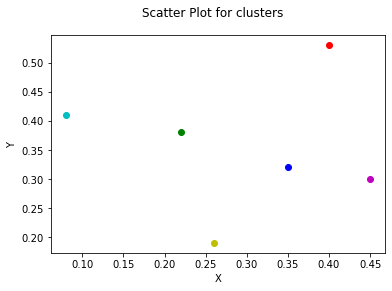

In [6]:
hierarchical_clustering(data,"single",6)

In [24]:
hierarchical_clustering(data,"single",6)

TypeError: 'int' object is not iterable

###### First data[5] and data[2] will merge, i.e. point P3 and P6 from the blog

[0, 1, 2, 3, 4, 2]


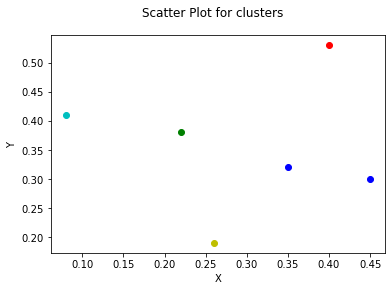

In [7]:
hierarchical_clustering(data,"single",5)
#you can see that the color of data[2] and data[5] became same, thus they are in same cluster now

###### Next merger data[1] and data[4],  i.e. P2 and P5 

[0, 1, 2, 3, 1, 2]


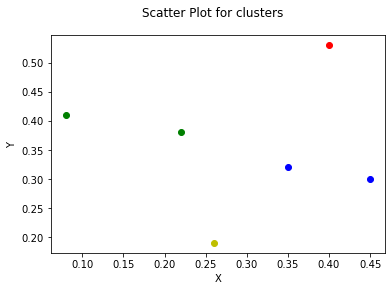

In [8]:
hierarchical_clustering(data,"single",4)
#you can see that the color of data[1] and data[4] also became same in color, thus they are in same cluster now

###### Next merger, 2 clusters formed above will merge

[0, 1, 1, 3, 1, 1]


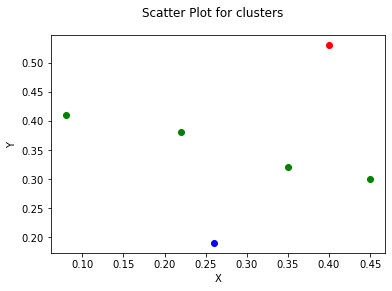

In [9]:
hierarchical_clustering(data,"single",3)

[0, 1, 1, 1, 1, 1]


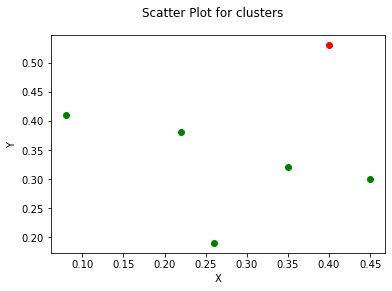

In [10]:
hierarchical_clustering(data,"single",2)

###### Finally all are in one cluster

[0, 0, 0, 0, 0, 0]


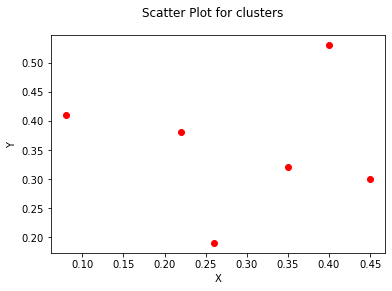

In [11]:
hierarchical_clustering(data,"single",1)